<a href="https://colab.research.google.com/github/jctovaruni-dev-1/uni-dcies-2025-estadistica-bayesiana-1/blob/main/UNI_DCIES2025_MAEB_TrabajoFinal_Nowcasting_MCMC_Nuts_Python_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
# ================================================================================================================
# UNI - DCIES 2025 - Curso: Modelos Avanzados de Estadística Bayesiana
#     Tema:           Trabajo Final 1 - Nowcasting de Casos de E. Coli en Alemania usando MCMC (HMC/NUTS)
#     Profesor:       Dr. Erick Chacon Montalvan
#     Autor:          Juan Carlos Tovar Ueda
#     Fecha:          Enero 2026
#     Descripción:    Implementación de un modelo bayesiano para nowcasting de casos de E. coli
#                     utilizando PyMC y MCMC (HMC/NUTS). El modelo estima la tasa real de casos
#                     diarios considerando retrasos en el reporte.
# ===============================================================================================================\
```



In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# Funcion de Preparación de Datos (cargar CSV y transformar en parametros de salida de datos)
#    Entrada:   archivo_csv:    Ruta y nombre del archivo.
#               fecha_actual:   Fecha de tope del calculo.
#    Salida:    observaciones:  Matriz de observaciones (dataset), que contiene los siguientes campos:
#                                   'date':               Fecha de ocurrencia (YYYY-MM-DD)
#                                   't_idx':              Dia de ocurrencia (se correlaciona con date)
#                                   'd_idx':              Dias de retraso (a partir del dia de ocurrencia)
#                                   'casos_observados':   Total de casos observados en dicho retraso
#               t_len:          Numero de dias de ocurrencia (filas)
#               d_len:          Numero de delays por ocurrencias (ej. 16)
#               date:           Vector de fechas (desde el inicio hasta el fin)
# -------------------------------------------------------------------------------------------------------------
def cargar_preparar_datos(archivo_csv, fecha_actual=None):

    # Cargar datos acumulados, le coloco como cabecera el nombre 'date'
    # a la primera columna, luego convierto su contenido a formato fecha
    df = pd.read_csv(archivo_csv)
    df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])

    # Extraer matriz de reportes acumulados (Y_cum)
    # Filas: Días de ocurrencia (t), Columnas: Días de retraso (d)
    # Aqui solo extraemos los datos de delay (no extraeremos los dias)
    Y_cum = df.filter(like='delay').values

    # Convertir de Acumulado a Incidental - Independiente (Y_inc)
    # n(t, d) = N(t, d) - N(t, d-1)
    # Esto es, pasar de una Frecuencia Acumulada a una Frecuencia Absoluta por dias.
    Y_inc = np.zeros_like(Y_cum)
    Y_inc[:, 0] = Y_cum[:, 0]
    Y_inc[:, 1:] = np.diff(Y_cum, axis=1)

    # Definir fecha de corte "Now" (fecha_actual): Simulación de tiempo real
    # Si no se define, usamos la última fecha del dataset
    if fecha_actual is None:
        fecha_actual = df['date'].iloc[-1]

    # Crear estructura para el modelo (Long Format)
    # Solo mantenemos datos donde (fecha_ocurrencia + retraso) <= fecha_actual
    observaciones = []
    t_len, d_len = Y_inc.shape
    for t_idx in range(t_len):  #-- Se recorren las filas
        date_t = df['date'].iloc[t_idx]
        for d_idx in range(d_len):   #-- Se recorren las columnas por cada fila
            date_report = date_t + pd.Timedelta(days=d_idx)
            # Condición de Nowcasting: ¿El reporte ya ocurrió?
            if date_report <= fecha_actual:
                observaciones.append({
                    'date': date_t,   #-- Fecha de ocurrencia (YYYY-MM-DD)
                    't_idx': t_idx,   #-- Dia de ocurrencia (se correlaciona con date)
                    'd_idx': d_idx,   #-- Dias de retraso (a partir del dia de ocurrencia)
                    'casos_observados': int(Y_inc[t_idx, d_idx])
                })

    return pd.DataFrame(observaciones), t_len, d_len, df['date']

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

# Define the path to your CSV file in Google Drive.
# IMPORTANT: Please update 'your_e_coli_data.csv' with the actual filename.
csv_filename = '/content/drive/MyDrive/Colab Datasets/husO104_tri_cumu.csv'

# Invoke the load_and_prep_data function
observations_df, t_len, d_len, dates = cargar_preparar_datos(csv_filename)

print(dates)
print(f"Se cargaron {len(observations_df)} observaciones.")
print(f"N° de dias de ocurrencia (filas): t_len: {t_len}")
print(f"N° de dias de atraso (delay) d_len: {d_len}")
print("Cabecera de Observaciones del DataFrame:")
print(observations_df.head(30))
print(observations_df.tail(20))

0    2011-05-07
1    2011-05-08
2    2011-05-09
3    2011-05-10
4    2011-05-11
5    2011-05-12
6    2011-05-13
7    2011-05-14
8    2011-05-15
9    2011-05-16
10   2011-05-17
11   2011-05-18
12   2011-05-19
13   2011-05-20
14   2011-05-21
15   2011-05-22
16   2011-05-23
17   2011-05-24
18   2011-05-25
19   2011-05-26
20   2011-05-27
21   2011-05-28
22   2011-05-29
23   2011-05-30
24   2011-05-31
25   2011-06-01
26   2011-06-02
27   2011-06-03
28   2011-06-04
29   2011-06-05
30   2011-06-06
31   2011-06-07
32   2011-06-08
33   2011-06-09
34   2011-06-10
35   2011-06-11
36   2011-06-12
37   2011-06-13
38   2011-06-14
39   2011-06-15
40   2011-06-16
41   2011-06-17
42   2011-06-18
43   2011-06-19
44   2011-06-20
45   2011-06-21
46   2011-06-22
47   2011-06-23
48   2011-06-24
49   2011-06-25
50   2011-06-26
51   2011-06-27
52   2011-06-28
53   2011-06-29
54   2011-06-30
55   2011-07-01
56   2011-07-02
57   2011-07-03
58   2011-07-04
Name: date, dtype: datetime64[ns]
Se cargaron 824 observ

In [ ]:
# Función del Modelo Bayesiano (PyMC) - Nowcasting con MCMC (HMC/NUTS)
# -------------------------------------------------------------------------------------------------------------
# Esta función estima la distribución posterior de los casos reales no observados (lambda_t).
#
# Entradas:
#    t_idx_obs:  np.array (int). Vector de índices temporales de ocurrencia [0, T-1].
#                Representa la coordenada 't' de cada observación en el triángulo.
#    d_idx_obs:  np.array (int). Vector de índices de retraso (delay) [0, D-1].
#                Representa el desplazamiento temporal del reporte.
#    y_obs:      np.array (int). Valores observados (conteo de casos) para cada par (t, d).
#                Es el 'target' o variable dependiente del modelo.
#    n_days:     int. Vector que define el horizonte temporal total (T).
#    n_delays:   int. Vector que define el retraso máximo observado (D).
#    es_rw:      (Opcional) Define si se calcula el lam_t como Gamma o como Randon Walk.
#
# Salida:
#    trace:      arviz.InferenceData. Contiene las muestras de la posterior generadas por MCMC.
#                Incluye las distribuciones para lambda_t, phi y b.
# -------------------------------------------------------------------------------------------------------------
#import pymc as pm

def nowcasting_mcmc_hmc(t_idx_obs, d_idx_obs, y_obs, n_days, n_delays, es_rw=False):

  with pm.Model() as model_nowcasting:

        # --- Priors ---
        # phi: Probabilidad de reporte inmediato (Eficiencia Inicial)
        # Definido en el texto como la proporción de casos registrados en d=0.
        # Se usa Uniforme[0,1] por ser una probabilidad, diferenciándose del
        # parámetro de sobre-dispersión de Günther et al. (2021).
        phi = pm.Uniform('phi', lower=0, upper=1)

        # b: Tasa de retraso (Tasa de decaimiento exponencial)
        # Controla la velocidad de reporte. Un prior Exponencial(1.0) asegura
        # valores positivos y una curva de decaimiento monótona.
        b = pm.Exponential('b', lam=1.0)

        lam_t = None
        if es_rw:
          # Mecanismo de reporte basado en Caminata Aleatoria (Günther et al., 2021)
          # Definimos la variabilidad día a día (sigma)
          sigma_lam = pm.Exponential('sigma_lam', lam=1.0)
          # En lugar de Gamma independiente, usamos GaussianRandomWalk
          # Esto conecta algebraicamente lambda[t] con lambda[t-1]
          log_lam_t = pm.GaussianRandomWalk('log_lam_t', sigma=sigma_lam, shape=n_days)
          # Transformamos de escala logarítmica a escala natural (Exponencial)
          # para asegurar que los casos sean siempre positivos
          lam_t = pm.Deterministic('lambda_t', pm.math.exp(log_lam_t))
        else:
          # Prior Gamma para incidencia diaria (Höhle, 2014)
          # Aprovecha la conjugación Poisson-Gamma para estabilidad en la inferencia.
          # lambda_t: Tasa real de casos por día (serie temporal)
          lam_t = pm.Gamma('lambda_t', alpha=1, beta=0.1, shape=n_days)

        # --- Mecanismo de Reporte Paramétrico (Ecuación 2 del informe) ---
        # p(d) acumulada: 1 - (1-phi)*exp(-b*d)
        # Necesitamos calcular q_d (probabilidad puntual) para d=0..15
        d_vals = np.arange(n_delays)

        # Cálculo vectorizado de la acumulada p(d): 1 - (1-phi)*exp(-b*d)
        p_d_cum = 1 - (1 - phi) * pm.math.exp(-b * d_vals)

        # Cálculo de la probabilidad puntual q(d) mediante diferencias discretas
        # q[0] = p[0]
        # q[d] = p[d] - p[d-1]
        q_0 = p_d_cum[0]
        q_rest = p_d_cum[1:] - p_d_cum[:-1]
        q_d_raw = pm.math.concatenate([[q_0], q_rest])

        # Normalización: Garantiza la restricción de cierre (suma de q_d = 1)
        # Esto es crucial porque truncamos los retrasos a 15 días
        q_d = q_d_raw / pm.math.sum(q_d_raw)

        # --- Verosimilitud (Likelihood) ---
        # Se asume estructura de Poisson para priorizar estabilidad numérica
        # sobre modelos de sobre-dispersión complejos en esta etapa.
        mu = lam_t[t_idx_obs] * q_d[d_idx_obs]

        # Observación
        Y_obs = pm.Poisson('Y_obs', mu=mu, observed=y_obs)

        # --- Inferencia (MCMC) ---
        # Implementación de HMC mediante el algoritmo NUTS para resolver la distribución posterior p(theta|y)
        # en espacios de alta dimensionalidad.
        # Aquí intentamos resolver la Distribución Posterior:
        # $$P(\lambda, \phi, b | Y) = \frac{P(Y|\lambda, \phi, b) P(\lambda) P(\phi) P(b)}{\int P(Y|\theta)P(\theta) d\theta}$$
        # El Problema: Esa integral del denominador es imposible de resolver analíticamente en altas dimensiones
        # (tienes cientos de $\lambda$s).
        # Usamos Hamiltonian Monte Carlo (HMC), que devuelve un trace: una colección de 2000 resultados de posibles valores para
        # los parámetros que representan la incertidumbre real del modelo.
        print("Iniciando muestreo MCMC (NUTS)...")
        trace = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

        return trace

Datos cargados: 824 observaciones válidas para el triángulo de reporte.
Iniciando muestreo MCMC (NUTS)...


Output()


--- Resultados (Últimos 10 días) ---
         date  casos_reportados_totales  estimado_nowcasting  lower_ci  \
49 2011-06-25                         1             2.690961  0.031979   
50 2011-06-26                         0             1.461587  0.000062   
51 2011-06-27                         1             3.259165  0.030147   
52 2011-06-28                         2             5.487255  0.514798   
53 2011-06-29                         0             2.105029  0.000163   
54 2011-06-30                         0             2.500680  0.000046   
55 2011-07-01                         0             3.013623  0.000496   
56 2011-07-02                         0             3.838442  0.003483   
57 2011-07-03                         0             5.401022  0.000271   
58 2011-07-04                         0             9.223717  0.000736   

     upper_ci  
49   6.289907  
50   4.255648  
51   7.927736  
52  11.824466  
53   6.163903  
54   7.593083  
55   8.929878  
56  11.620935  
57 

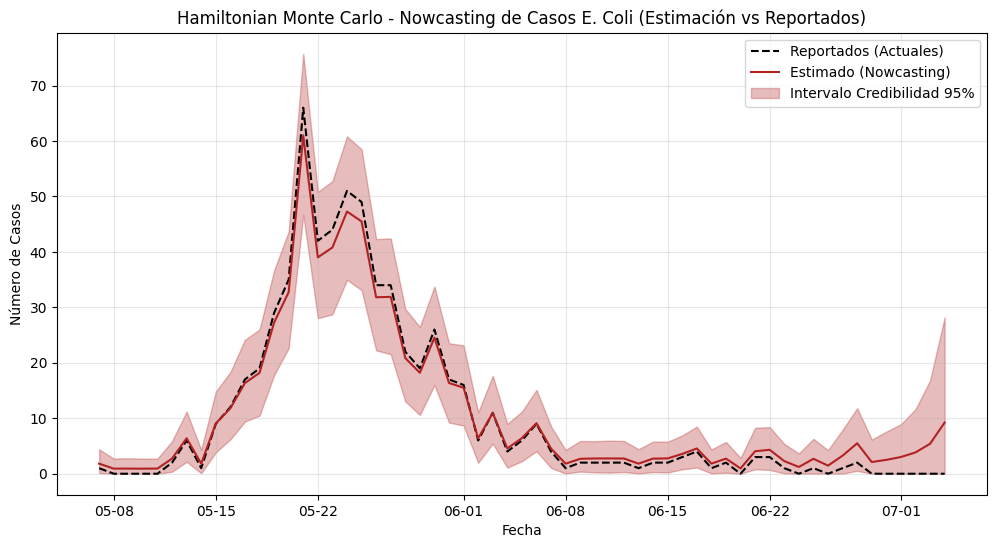


Resumen de parámetros globales:
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
phi  0.002  0.001   0.000    0.005        0.0      0.0    4616.0    2348.0   
b    0.025  0.009   0.008    0.041        0.0      0.0    4107.0    1907.0   

     r_hat  
phi    1.0  
b      1.0  


In [ ]:
# Resultados y Visualización - Ultima fecha de corte (fecha con eventos no reportados) - Sin caminata aleatoria
# -------------------------------------------------------------------------------------------------------------

from google.colab import drive
# drive.mount('/content/drive')

# Cargar datos (Asegúrate de tener el archivo en el mismo directorio)
# Simularemos que estamos en el último día del registro
csv_filename = '/content/drive/MyDrive/Colab Datasets/husO104_tri_cumu.csv'

# Invocar la funcion cargar_preparar_datos(): Ultima fecha de corte (fecha con eventos no reportados)
data, n_days, n_delays, dates = cargar_preparar_datos(csv_filename)

# Indices para PyMC
t_idx_obs = data['t_idx'].values
d_idx_obs = data['d_idx'].values
y_obs = data['casos_observados'].values

print(f"Datos cargados: {len(y_obs)} observaciones válidas para el triángulo de reporte.")

# Ejecutar modelo bayesiano (PyMC) - Nowcasting con MCMC (HMC/NUTS)
trace = nowcasting_mcmc_hmc(t_idx_obs, d_idx_obs, y_obs, n_days, n_delays)

# Extraer los limites del resultado (lower y upper)
hdi_lambda = az.hdi(trace.posterior['lambda_t'], hdi_prob=0.95)['lambda_t'].values

# Extraer medias posteriores de lambda (Casos Reales Estimados)
casos_reportados_totales = [data[data['t_idx']==i]['casos_observados'].sum() for i in range(n_days)]
posterior_lambda = trace.posterior['lambda_t'].mean(dim=["chain", "draw"]).values

# Crear DataFrame de resultados
results = pd.DataFrame({
    'date': dates,
    'casos_reportados_totales': casos_reportados_totales,
    'estimado_nowcasting': posterior_lambda,
    'lower_ci': hdi_lambda[:, 0],
    'upper_ci': hdi_lambda[:, 1]
})

print("\n--- Resultados (Últimos 10 días) ---")
print(results.tail(10))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(results['date'], results['casos_reportados_totales'], label='Reportados (Actuales)', color='black', linestyle='--')
plt.plot(results['date'], results['estimado_nowcasting'], label='Estimado (Nowcasting)', color='firebrick')
plt.fill_between(results['date'], results['lower_ci'], results['upper_ci'], color='firebrick', alpha=0.3, label='Intervalo Credibilidad 95%')

plt.title('Hamiltonian Monte Carlo - Nowcasting de Casos E. Coli (Estimación vs Reportados)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.show()

# Diagnósticos básicos
print("\nResumen de parámetros globales:")
print(az.summary(trace, var_names=['phi', 'b']))

Datos cargados: 376 observaciones válidas para el triángulo de reporte.
Iniciando muestreo MCMC (NUTS)...


Output()


--- Resultados (Últimos 10 días) ---
         date  casos_reportados_totales  estimado_nowcasting  lower_ci  \
49 2011-06-25                         0            10.164786  0.002634   
50 2011-06-26                         0             9.871328  0.009914   
51 2011-06-27                         0             9.993628  0.001748   
52 2011-06-28                         0             9.942341  0.001248   
53 2011-06-29                         0            10.024649  0.000668   
54 2011-06-30                         0             9.945320  0.005907   
55 2011-07-01                         0            10.003973  0.002608   
56 2011-07-02                         0             9.899077  0.005005   
57 2011-07-03                         0            10.223611  0.000758   
58 2011-07-04                         0            10.024597  0.002813   

     upper_ci  
49  31.185717  
50  28.931391  
51  29.755484  
52  29.984365  
53  28.959541  
54  30.300922  
55  29.549987  
56  28.666210  
57 

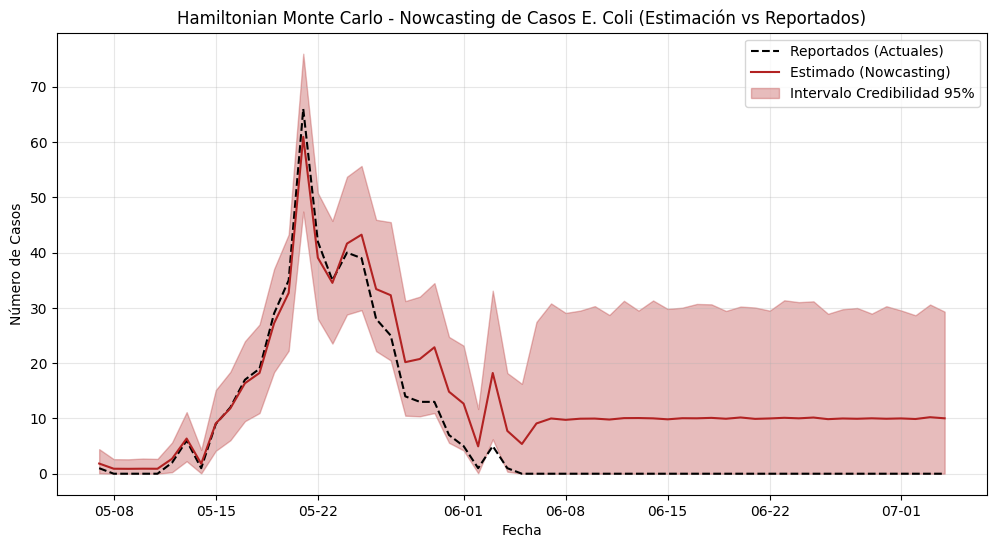


Resumen de parámetros globales:
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
phi  0.002  0.001   0.000    0.004        0.0      0.0    3247.0    2059.0   
b    0.022  0.010   0.004    0.039        0.0      0.0    3270.0    2027.0   

     r_hat  
phi    1.0  
b      1.0  


In [ ]:
# Resultados y Visualización - Mitad de fecha (para validacion del modelo) - Sin caminata aleatoria
# -------------------------------------------------------------------------------------------------------------

from google.colab import drive
# drive.mount('/content/drive')

# Cargar datos (Asegúrate de tener el archivo en el mismo directorio)
# Simularemos que estamos en el último día del registro
csv_filename = '/content/drive/MyDrive/Colab Datasets/husO104_tri_cumu.csv'

# Invocar la funcion cargar_preparar_datos(): Mitad de fecha (para validacion del modelo)
fecha_mitad_corte = pd.to_datetime('2011-06-06')
data, n_days, n_delays, dates = cargar_preparar_datos(csv_filename, fecha_actual=fecha_mitad_corte)

# Indices para PyMC
t_idx_obs = data['t_idx'].values
d_idx_obs = data['d_idx'].values
y_obs = data['casos_observados'].values

print(f"Datos cargados: {len(y_obs)} observaciones válidas para el triángulo de reporte.")

# Ejecutar modelo bayesiano (PyMC) - Nowcasting con MCMC (HMC/NUTS)
trace = nowcasting_mcmc_hmc(t_idx_obs, d_idx_obs, y_obs, n_days, n_delays)

# Extraer los limites del resultado (lower y upper)
hdi_lambda = az.hdi(trace.posterior['lambda_t'], hdi_prob=0.95)['lambda_t'].values

# Extraer medias posteriores de lambda (Casos Reales Estimados)
casos_reportados_totales = [data[data['t_idx']==i]['casos_observados'].sum() for i in range(n_days)]
posterior_lambda = trace.posterior['lambda_t'].mean(dim=["chain", "draw"]).values

# Crear DataFrame de resultados
results = pd.DataFrame({
    'date': dates,
    'casos_reportados_totales': casos_reportados_totales,
    'estimado_nowcasting': posterior_lambda,
    'lower_ci': hdi_lambda[:, 0],
    'upper_ci': hdi_lambda[:, 1]
})

print("\n--- Resultados (Últimos 10 días) ---")
print(results.tail(10))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(results['date'], results['casos_reportados_totales'], label='Reportados (Actuales)', color='black', linestyle='--')
plt.plot(results['date'], results['estimado_nowcasting'], label='Estimado (Nowcasting)', color='firebrick')
plt.fill_between(results['date'], results['lower_ci'], results['upper_ci'], color='firebrick', alpha=0.3, label='Intervalo Credibilidad 95%')

plt.title('Hamiltonian Monte Carlo - Nowcasting de Casos E. Coli (Estimación vs Reportados)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.show()

# Diagnósticos básicos
print("\nResumen de parámetros globales:")
print(az.summary(trace, var_names=['phi', 'b']))

In [ ]:
# Resultados y Visualización - Mitad de fecha (para validacion del modelo) - Con caminata aleatoria
# -------------------------------------------------------------------------------------------------------------

from google.colab import drive
# drive.mount('/content/drive')

# Cargar datos (Asegúrate de tener el archivo en el mismo directorio)
# Simularemos que estamos en el último día del registro
csv_filename = '/content/drive/MyDrive/Colab Datasets/husO104_tri_cumu.csv'

# Invocar la funcion cargar_preparar_datos(): Mitad de fecha (para validacion del modelo)
fecha_mitad_corte = pd.to_datetime('2011-06-06')
data, n_days, n_delays, dates = cargar_preparar_datos(csv_filename, fecha_actual=fecha_mitad_corte)

# Indices para PyMC
t_idx_obs = data['t_idx'].values
d_idx_obs = data['d_idx'].values
y_obs = data['casos_observados'].values

print(f"Datos cargados: {len(y_obs)} observaciones válidas para el triángulo de reporte.")

# Ejecutar modelo bayesiano (PyMC) - Nowcasting con MCMC (HMC/NUTS)
trace = nowcasting_mcmc_hmc(t_idx_obs, d_idx_obs, y_obs, n_days, n_delays, True)

# Extraer los limites del resultado (lower y upper)
hdi_lambda = az.hdi(trace.posterior['lambda_t'], hdi_prob=0.95)['lambda_t'].values

# Extraer medias posteriores de lambda (Casos Reales Estimados)
casos_reportados_totales = [data[data['t_idx']==i]['casos_observados'].sum() for i in range(n_days)]
posterior_lambda = trace.posterior['lambda_t'].mean(dim=["chain", "draw"]).values

# Crear DataFrame de resultados
results = pd.DataFrame({
    'date': dates,
    'casos_reportados_totales': casos_reportados_totales,
    'estimado_nowcasting': posterior_lambda,
    'lower_ci': hdi_lambda[:, 0],
    'upper_ci': hdi_lambda[:, 1]
})

print("\n--- Resultados (Últimos 10 días) ---")
print(results.tail(10))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(results['date'], results['casos_reportados_totales'], label='Reportados (Actuales)', color='black', linestyle='--')
plt.plot(results['date'], results['estimado_nowcasting'], label='Estimado (Nowcasting)', color='firebrick')
plt.fill_between(results['date'], results['lower_ci'], results['upper_ci'], color='firebrick', alpha=0.3, label='Intervalo Credibilidad 95%')

plt.title('Hamiltonian Monte Carlo - Nowcasting de Casos E. Coli (Estimación vs Reportados)')
plt.xlabel('Fecha')
plt.ylabel('Número de Casos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.show()

# Diagnósticos básicos
print("\nResumen de parámetros globales:")
print(az.summary(trace, var_names=['phi', 'b']))